<a href="https://colab.research.google.com/github/Ahmad-abdulrahim/IT-Jobpost-Classification-Job-Title-Similarity/blob/main/Job_Classifier_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import necessary libraries**

In [ ]:
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical computations
import re           # For regular expressions
import nltk         # Natural Language Toolkit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords   # Stopwords
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.stem import WordNetLemmatizer  # Lemmatization
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
!pip install lime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=045246dc5d767eb7f05e49afc113ef0dcdb3fd7e6f464a9b4cd700fab1622e1c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# Job posts dataset exploration

## Dataset information

In [ ]:
from google.colab import files
files.upload()  # Upload Kaggle API token (kaggle.json)
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d udacity/armenian-online-job-postings

Saving kaggle.json to kaggle.json
 64% 9.00M/14.0M [00:00<00:00, 30.5MB/s]
100% 14.0M/14.0M [00:00<00:00, 41.0MB/s]


In [ ]:
!unzip armenian-online-job-postings.zip

Archive:  armenian-online-job-postings.zip
  inflating: example-job-posting.jpg  
  inflating: features.txt            
  inflating: online-job-postings.csv  


In [ ]:
#reading the dataset
jobs = pd.read_csv("online-job-postings.csv")
jobs.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [ ]:
#displaying the columns
jobs.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

In [ ]:
#displaying the shape of the dataframe
jobs.shape

(19001, 24)

In [ ]:
#displaying the information of the dataframe
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

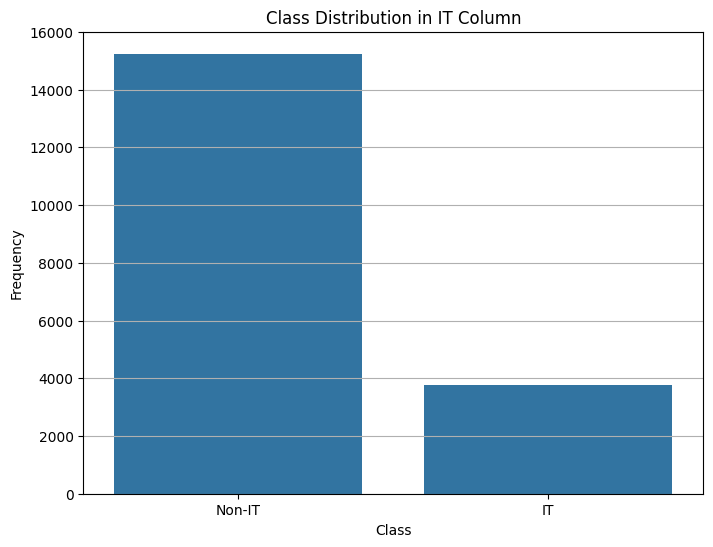

In [ ]:
#visualizing the class distribution in IT COLUMNS
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))  # Setting the figure size
sns.countplot(x='IT', data=jobs)  # Plotting the count of each class in the 'IT' column

plt.title('Class Distribution in IT Column')  # Title of the plot
plt.xlabel('Class')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks([0, 1], ['Non-IT', 'IT'])  # Customizing x-axis ticks for clarity
plt.grid(axis='y')  # Adding a grid for better readability

plt.show()

## Dataset Cleaning

In [ ]:
#removing duplicate jobposts based on title and post
jobs = jobs.drop_duplicates(['jobpost', 'Title'])

In [ ]:
#removing records with null titles
jobs = jobs[jobs.Title.notna()]

In [ ]:
jobs.shape

(18865, 24)

In [ ]:
# Remove leading and trailing spaces from column names
jobs.columns = jobs.columns.str.strip()
# Rename specific columns for clarity and consistency
jobs.rename(columns={'date': 'Date', 'jobpost': 'Jobpost', 'RequiredQual': 'RequiredQualifications', 'JobRequirment': 'JobRequirement'}, inplace=True)

In [ ]:
#displaying the dataframe info
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18865 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Jobpost                 18865 non-null  object
 1   Date                    18865 non-null  object
 2   Title                   18865 non-null  object
 3   Company                 18865 non-null  object
 4   AnnouncementCode        1202 non-null   object
 5   Term                    7650 non-null   object
 6   Eligibility             4869 non-null   object
 7   Audience                631 non-null    object
 8   StartDate               9638 non-null   object
 9   Duration                10752 non-null  object
 10  Location                18840 non-null  object
 11  JobDescription          15040 non-null  object
 12  JobRequirement          16409 non-null  object
 13  RequiredQualifications  18437 non-null  object
 14  Salary                  9582 non-null   object
 15  Applica

In [ ]:
# Convert all column values to string type except for the 'IT' column, preserving NaN values
for col in jobs.columns:
    if col != 'IT':  # Skip the "IT" column
        jobs[col] = jobs[col].apply(lambda x: x if pd.isna(x) else str(x))

In [ ]:
#displaying the dataframe info
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18865 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Jobpost                 18865 non-null  object
 1   Date                    18865 non-null  object
 2   Title                   18865 non-null  object
 3   Company                 18865 non-null  object
 4   AnnouncementCode        1202 non-null   object
 5   Term                    7650 non-null   object
 6   Eligibility             4869 non-null   object
 7   Audience                631 non-null    object
 8   StartDate               9638 non-null   object
 9   Duration                10752 non-null  object
 10  Location                18840 non-null  object
 11  JobDescription          15040 non-null  object
 12  JobRequirement          16409 non-null  object
 13  RequiredQualifications  18437 non-null  object
 14  Salary                  9582 non-null   object
 15  Applica

# Exploratory Data Analysis (EDA)


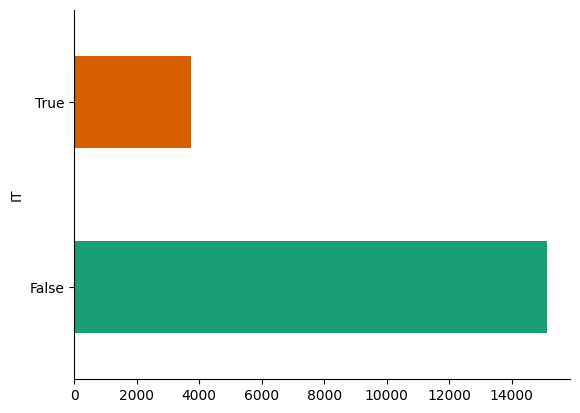

In [ ]:
# Plot horizontal bar chart of the number of records for each 'IT' category
from matplotlib import pyplot as plt
import seaborn as sns
jobs.groupby('IT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))  # Group by 'IT', count, and plot
plt.gca().spines[['top', 'right',]].set_visible(False)  # Hide top and right spines for aesthetics

## Title analysis

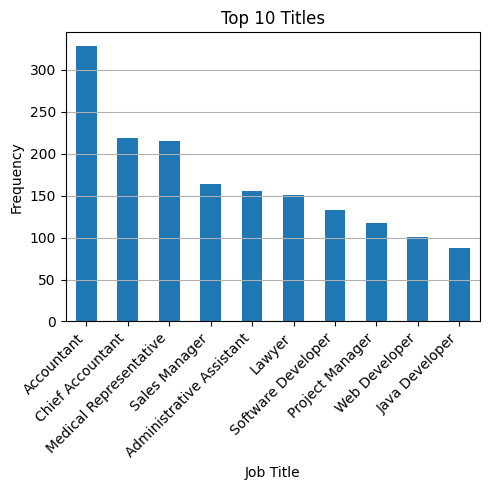

In [ ]:
# Plotting the top 30 job titles
top_30_job_titles = jobs['Title'].value_counts().nlargest(10)

plt.figure(figsize=(5, 5))
top_30_job_titles.plot(kind='bar')
plt.title('Top 10 Titles')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate the job titles on x-axis for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.grid(axis='y')
plt.show()

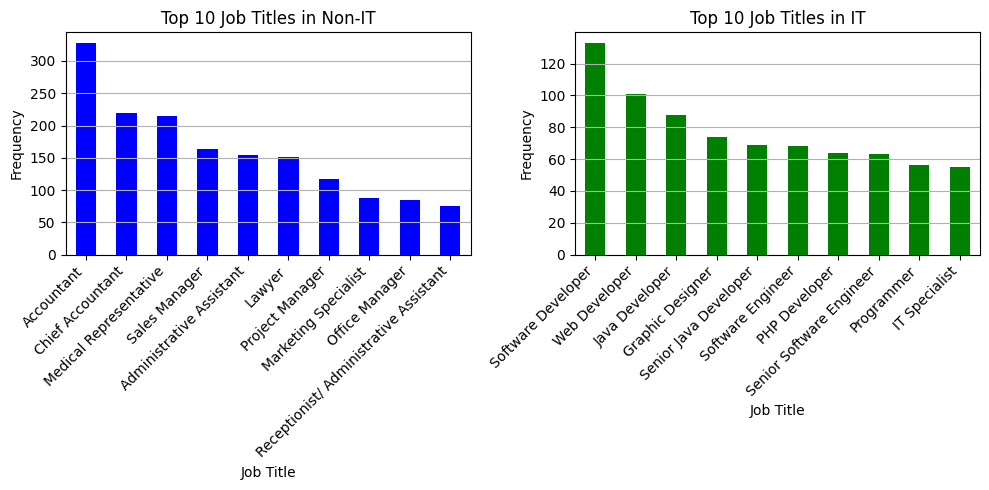

In [ ]:
#visualization of IT and non IT job titles
non_it_jobs = jobs[jobs['IT'] == 0]['Title'].value_counts().head(10)
it_jobs = jobs[jobs['IT'] == 1]['Title'].value_counts().head(10)

plt.figure(figsize=(10, 5))

# First subplot for non-IT jobs
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
non_it_jobs.plot(kind='bar', color='blue')
plt.title('Top 10 Job Titles in Non-IT')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y")

# Second subplot for IT jobs
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
it_jobs.plot(kind='bar', color='green')
plt.title('Top 10 Job Titles in IT')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Load the small English model from spaCy with default pipeline components for basic text processing
nlp = spacy.load("en_core_web_sm")

In [ ]:
#Enhanced Text Preprocessing with SpaCy
def preprocess_text_spacy(text):

    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.strip().lower()  # Strip whitespace and convert to lowercase
    text = re.sub(r'http\S+', '', text) # Remove Url from text
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatize, remove stopwords and punctuation
    return " ".join(tokens)  # Join tokens into a string

In [ ]:
title = jobs.Title.apply(lambda x : preprocess_text_spacy(x))  # Apply preprocessing function to 'Title' column
title.head()  # Display the first 5 processed titles

0                              chief financial officer
1    fulltime community connection intern pay inter...
2                                  country coordinator
3                                       bcc specialist
4                                   software developer
Name: Title, dtype: object

To gain insight into the most sought-after jobs in Armenia, we can analyze job titles using a technique that constructs a document-term matrix (DTM) based on bi-grams or tri-grams. A bi-gram or tri-gram approach breaks down the job titles into pairs or triplets of consecutive words, respectively. By creating this matrix, we can identify which combinations of words (tokens) appear most frequently within the job titles. The most frequently occurring bi-gram or tri-gram can be interpreted as an indicator of the job roles that are currently in highest demand.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer for tokenization, using unigrams
count_vect = CountVectorizer(ngram_range=(1,1))
token = count_vect.fit_transform(title)  # Fit and transform the 'title' series to tokens

In [ ]:
print('Total number of tokens/words in all the job titles - ',
      len(count_vect.get_feature_names_out()))

Total number of tokens/words in all the job titles -  2858


In [ ]:
title_df =  pd.DataFrame(token.toarray(), columns=count_vect.get_feature_names_out())
title_df.tail()

,aaca,abap,abatement,abattoir,abkhazia,abovyan,abuse,ac,academy,acca,...,yoga,young,youth,zang,zend,zonal,zone,zooplankton,zvartnot,zvartnots
18860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#count the occurence of each token in entire corpus
title_count_df = title_df.apply(lambda x : x.sum())

In [ ]:
title_count_df = pd.DataFrame(title_count_df).reset_index()

In [ ]:
title_count_df.columns = ['Word', 'Count']

In [ ]:
top_title = title_count_df.sort_values(by= 'Count', ascending=False)
top_title[:15]

,Word,Count
1551,manager,2587
2411,specialist,2067
716,developer,1943
868,engineer,1603
2325,senior,1490
208,assistant,1234
2390,software,1099
2260,sale,853
15,accountant,779
704,department,742


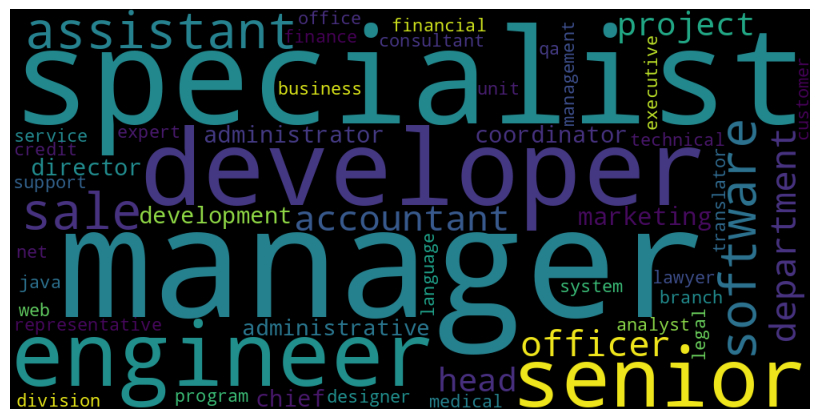

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(top_title[:50].Word))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

A dispersion plot can be utilized to track the evolution of job roles over time. This involves extracting key topics from job postings and then visualizing their frequency and distribution across different time periods. Essentially, by identifying and plotting these significant themes, we can observe trends and shifts in job demands over the years, providing insights into how certain job roles emerge, evolve, or decline.

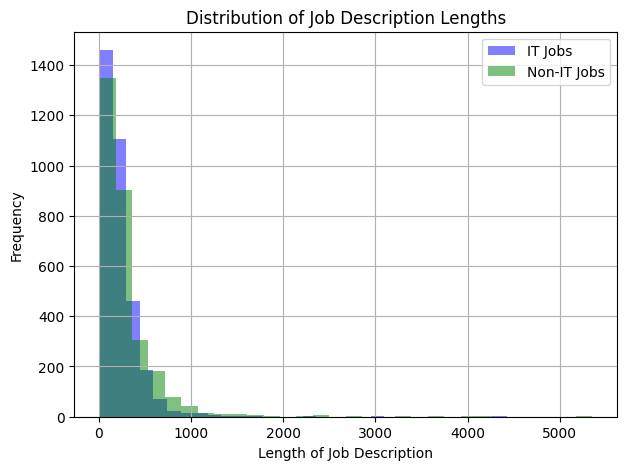

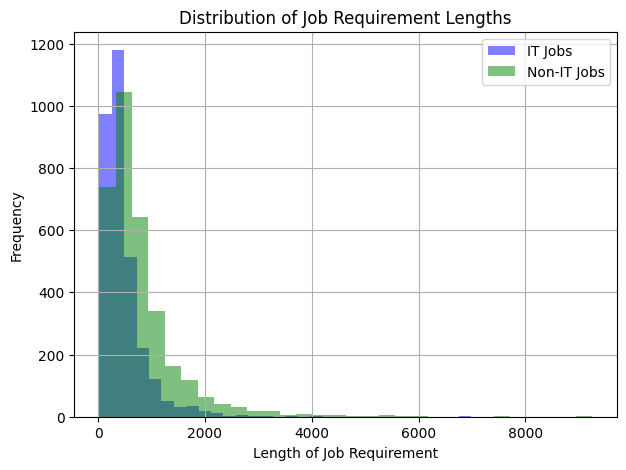

In [ ]:
# Calculate the length of job descriptions and requirements
jobs['JobDescription_length'] = jobs['JobDescription'].str.len()
jobs['JobRequirement_length'] = jobs['JobRequirement'].str.len()

# Balancing the dataset
it_jobs = jobs[jobs['IT']]
non_it_jobs = jobs[~jobs['IT']]

# Sample the minimum count from both categories to ensure balance
min_count = min(len(it_jobs), len(non_it_jobs))
balanced_it_jobs = it_jobs.sample(min_count, random_state=42)
balanced_non_it_jobs = non_it_jobs.sample(min_count, random_state=42)

# Combine back to a balanced dataframe
balanced_jobs = pd.concat([balanced_it_jobs, balanced_non_it_jobs])

# Plotting histograms for Job Description Lengths
plt.figure(figsize=(7, 5))
plt.hist(balanced_jobs[balanced_jobs['IT']]['JobDescription_length'], bins=30, alpha=0.5, label='IT Jobs', color='blue')
plt.hist(balanced_jobs[~balanced_jobs['IT']]['JobDescription_length'], bins=30, alpha=0.5, label='Non-IT Jobs', color='green')
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Length of Job Description')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plotting histograms for Job Requirement Lengths
plt.figure(figsize=(7, 5))
plt.hist(balanced_jobs[balanced_jobs['IT']]['JobRequirement_length'], bins=30, alpha=0.5, label='IT Jobs', color='blue')
plt.hist(balanced_jobs[~balanced_jobs['IT']]['JobRequirement_length'], bins=30, alpha=0.5, label='Non-IT Jobs', color='green')
plt.title('Distribution of Job Requirement Lengths')
plt.xlabel('Length of Job Requirement')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Pickle file Checkpoint: Jobpost Preprocessed

In [ ]:
import gzip
import pandas as pd
import pickle

# Load the compressed pickle file in binary mode
with gzip.open('processed_jobpost.pkl.gz', 'rb') as f:  # Note the 'rb' mode here
    loaded_data = pickle.load(f)

# Assuming the loaded data contains a dictionary with a key 'jobs' that holds the DataFrame
jobs_processed = loaded_data['jobs']

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

#Preprocessing job post column (Skip if imported pickle file)

In [ ]:
jobpost = jobs.Jobpost.apply(lambda x : preprocess_text_spacy(x))
jobpost.head(10)

0    ameria investment consult company job title ch...
1    international research exchange board irex tit...
2    caucasus environmental ngo network cenn job ti...
3    manoff group job title bcc specialist position...
4    yerevan brandy company job title software deve...
5    boutique appollo job title saleswoman position...
6    osi assistance foundation armenian branch offi...
7    international research exchange board irex tit...
8    yerevan brandy company job title assistant man...
9    american embassy yerevan announcement number j...
Name: Jobpost, dtype: object

In [ ]:
title

0                                  chief financial officer
1        fulltime community connection intern pay inter...
2                                      country coordinator
3                                           bcc specialist
4                                       software developer
                               ...                        
18996                       senior creative ux ui designer
18997                         category development manager
18998                        operational marketing manager
18999                          head online sale department
19000                              lawyer legal department
Name: Title, Length: 18865, dtype: object

In [ ]:
jobpost_preprocessed = pd.DataFrame({'Jobpost':jobpost,'Title':title})

In [ ]:
#Preview of the Top 5 Preprocessed Job Posts
jobpost_preprocessed.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [ ]:
import gzip
import pickle

# Save the processed jobpost df and selected columns to a compressed pickle file
selected_columns = ['Jobpost', 'Title']

processed_data = {
    'jobs': jobpost_preprocessed[selected_columns]
}

with gzip.open('processed_jobpost.pkl.gz', 'wb') as f:
    pickle.dump(processed_data, f)

#Job post Analysis

In [ ]:
#Preview of the Top 5 processed Job Posts
jobs_processed.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [ ]:
jobs_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18865 entries, 0 to 19000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Jobpost  18865 non-null  object
 1   Title    18865 non-null  object
dtypes: object(2)
memory usage: 442.1+ KB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with specific conditions and apply it to 'jobpost'
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)
token_jobpost = tfidf.fit_transform(jobs_processed['Jobpost'])  # Fit and transform 'jobpost' to TF-IDF features
vocab = tfidf.get_feature_names_out()  # Extract the vocabulary of terms found in the documents

In [ ]:
jobpost_token = pd.DataFrame(token_jobpost.toarray(), columns=tfidf.get_feature_names_out())
jobpost_token.head()

,ability,ability work,access,accord,accordance,account,accountant,accounting,accuracy,accurate,...,write communication,write speak,writing,year,year experience,year professional,year relevant,year work,yerevan,yerevan armenia
0,0.042334,0.019176,0.0,0.0,0.0,0.097952,0.0,0.23532,0.0,0.0,...,0.0,0.00000,0.033011,0.013172,0.000000,0.0,0.000000,0.0,0.009992,0.010207
1,0.034500,0.046881,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.146567,0.049907
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.000000,0.035537,0.000000,0.0,0.096479,0.0,0.026956,0.027536
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.04769,0.000000,0.016988,0.031362,0.0,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.000000,0.057678,0.106481,0.0,0.000000,0.0,0.131251,0.044692


In [ ]:
column_names = jobpost_token.columns.tolist()
print(column_names)

['ability', 'ability work', 'access', 'accord', 'accordance', 'account', 'accountant', 'accounting', 'accuracy', 'accurate', 'achieve', 'act', 'action', 'activity', 'additional', 'additional note', 'address', 'administration', 'administrative', 'advanced', 'advantage', 'agency', 'agreement', 'aim', 'amd', 'analysis', 'analytical', 'analytical skill', 'analyze', 'andor', 'announcement code', 'announcement download', 'annual', 'applicant', 'application form', 'apply', 'apply position', 'apply subject', 'approach', 'appropriate', 'april', 'april application', 'april company', 'area', 'armenia place', 'armenia title', 'armenian', 'armenian english', 'armenian language', 'armenian russian', 'asap', 'asap duration', 'asap location', 'ask', 'aspect', 'assessment', 'asset', 'assign', 'assist', 'assistance', 'assistant', 'attach', 'attachment', 'attachment announcement', 'attachment follow', 'attention', 'attention detail', 'august', 'august application', 'august company', 'authority', 'availab

Latent Dirichlet Allocation (LDA) technique, a type of topic modeling, to analyze and understand the main themes or natures of jobs from tokenized job postings. The goal is to identify clusters of words that represent significant topics within the job posts, which can help in understanding the nature and profiles of jobs.

In [ ]:
# Apply LDA to discern significant aspects of job nature and profiles
from sklearn import decomposition

# Initialize LDA model
lda = decomposition.LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=50, random_state=3)
lda.fit_transform(token_jobpost)  # Fit and transform TF-IDF features to LDA
topics = lda.components_  # Extract the components (topics) from the LDA model

In [ ]:
topics

array([[2.19845612e+02, 9.04047124e+01, 2.16534468e+01, ...,
        8.37702802e+01, 1.41007194e+02, 1.29749284e+02],
       [1.68878914e+02, 5.87939074e+01, 4.78811327e+01, ...,
        2.38550454e+01, 1.35694147e+02, 8.70316739e+01],
       [2.67784364e+02, 1.68779920e+02, 1.69316750e+01, ...,
        8.83121957e+01, 2.61998408e+02, 2.21854638e+02],
       [9.15730460e+00, 7.57936170e+00, 2.03954371e-01, ...,
        1.34838129e+01, 7.54321656e+00, 8.56659842e+00],
       [1.13534349e+02, 7.16248858e+01, 1.00893458e+01, ...,
        5.25742904e+01, 9.06714536e+01, 6.58592124e+01]])

In [ ]:
# Generate summaries for each topic with the top words
n_top_words = 15
topic_summaries = []
for i, topic_dist in enumerate(topics):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]  # Select top words for each topic
    topic_summaries.append(' '.join(topic_words))  # Create summary string

topic_summaries  # Display the topic summaries

['software design development developer experience knowledge web test work team company system engineer software development technology',
 'project program development management international work training support activity ensure office provide experience implementation skill',
 'sale company work customer skill knowledge marketing llc language candidate excellent russian time experience term',
 'accounting financial accountant tax finance chief account report prepare payment statement control legislation transaction budget',
 'bank credit cjsc banking application form form knowledge legal attachment skill candidate work service financial branch']

In [ ]:
topic_words_tokens = []
for topic in topic_summaries:
    word_token = nltk.word_tokenize(topic)  # Tokenize each topic summary
    topic_words_tokens.extend(word_token)  # Append tokens to list
print(topic_words_tokens)  # Print the list of tokens from all topic summaries

['software', 'design', 'development', 'developer', 'experience', 'knowledge', 'web', 'test', 'work', 'team', 'company', 'system', 'engineer', 'software', 'development', 'technology', 'project', 'program', 'development', 'management', 'international', 'work', 'training', 'support', 'activity', 'ensure', 'office', 'provide', 'experience', 'implementation', 'skill', 'sale', 'company', 'work', 'customer', 'skill', 'knowledge', 'marketing', 'llc', 'language', 'candidate', 'excellent', 'russian', 'time', 'experience', 'term', 'accounting', 'financial', 'accountant', 'tax', 'finance', 'chief', 'account', 'report', 'prepare', 'payment', 'statement', 'control', 'legislation', 'transaction', 'budget', 'bank', 'credit', 'cjsc', 'banking', 'application', 'form', 'form', 'knowledge', 'legal', 'attachment', 'skill', 'candidate', 'work', 'service', 'financial', 'branch']


In [ ]:
vocab = []  # Initialize empty list to store vocabulary

def fn_token(post):
    list_temp = nltk.word_tokenize(post)  # Tokenize the post
    vocab.extend(list_temp)  # Extend the vocab list with tokens

jobpost.apply(lambda x: fn_token(x))  # Apply tokenization function to each job post

0        None
1        None
2        None
3        None
4        None
         ... 
18996    None
18997    None
18998    None
18999    None
19000    None
Name: Jobpost, Length: 18865, dtype: object

In [ ]:
full_vocab = []  # Initialize empty list for unique vocabulary

for word in vocab:
    if word not in full_vocab:  # Check if word is not already in full_vocab
        full_vocab.append(word)  # Add unique word to full_vocab

<Figure size 1500x1000 with 0 Axes>

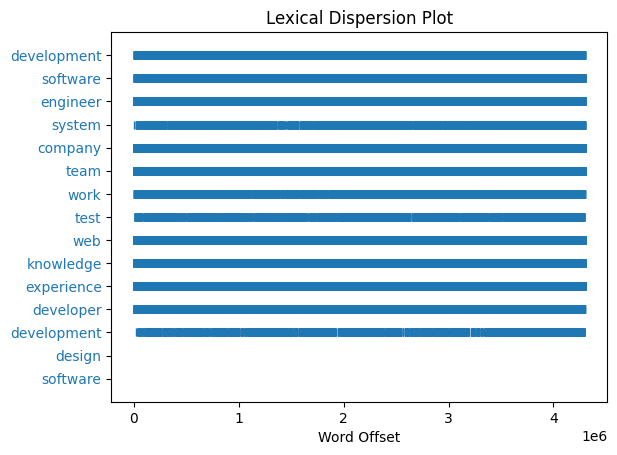

In [ ]:
# Visualize the dispersion of the top 15 topic words across the text
from nltk.draw.dispersion import dispersion_plot

plt.figure(figsize=(15, 10))  # Increase figure size to make the plot less cluttered
dispersion_plot(vocab, topic_words_tokens[:15])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

# Extracting topics with their words and probabilities
n_top_words = 15
words = np.array(tfidf.get_feature_names_out())
topic_word_distributions = np.array([np.argsort(topic)[:-(n_top_words+1):-1] for topic in lda.components_])

# Create a DataFrame to store topics and corresponding words for easier manipulation
import pandas as pd
topic_words = pd.DataFrame(index=["Topic " + str(i) for i in range(len(topic_word_distributions))],
                           columns=["Word " + str(j) for j in range(n_top_words)],
                           data=words[topic_word_distributions])


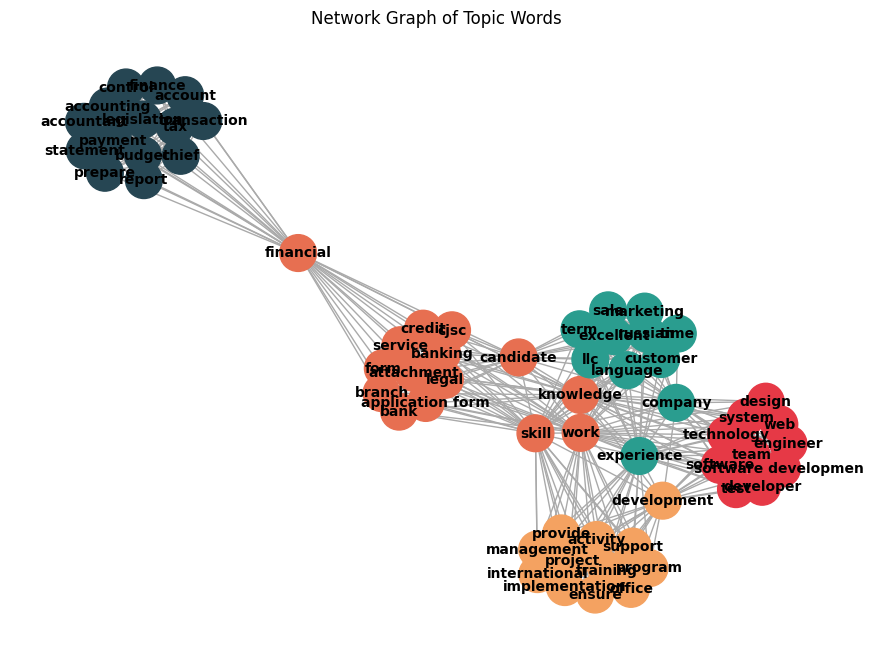

In [ ]:
# Create a color map for topics
# Generating different shades of purple
colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653', '#E76F51']  # Rich and contrasting colors

# Assign a color to each topic index
topic_color = {f"Topic {i}": colors[i % len(colors)] for i in range(len(words[topic_word_distributions]))}

# Adding nodes and assigning colors based on their topic
for topic_idx, words_in_topic in enumerate(words[topic_word_distributions]):
    for word in words_in_topic:
        G.add_node(word, topic=f"Topic {topic_idx}", color=topic_color[f"Topic {topic_idx}"])

    # Connect every word in the topic to every other word
    for i in range(len(words_in_topic)):
        for j in range(i + 1, len(words_in_topic)):
            if not G.has_edge(words_in_topic[i], words_in_topic[j]):
                G.add_edge(words_in_topic[i], words_in_topic[j], weight=1)
            else:
                G[words_in_topic[i]][words_in_topic[j]]['weight'] += 1

# Drawing the network graph
plt.figure(figsize=(11, 8))
pos = nx.spring_layout(G, k=0.15, iterations=100)

# Draw nodes with assigned colors
node_colors = [data['color'] for node, data in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
nx.draw_networkx_edges(G, pos, edge_color='#AAAAAA')  # Grey color for edges
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Network Graph of Topic Words')
plt.axis('off')  # Turn off the axis
plt.show()


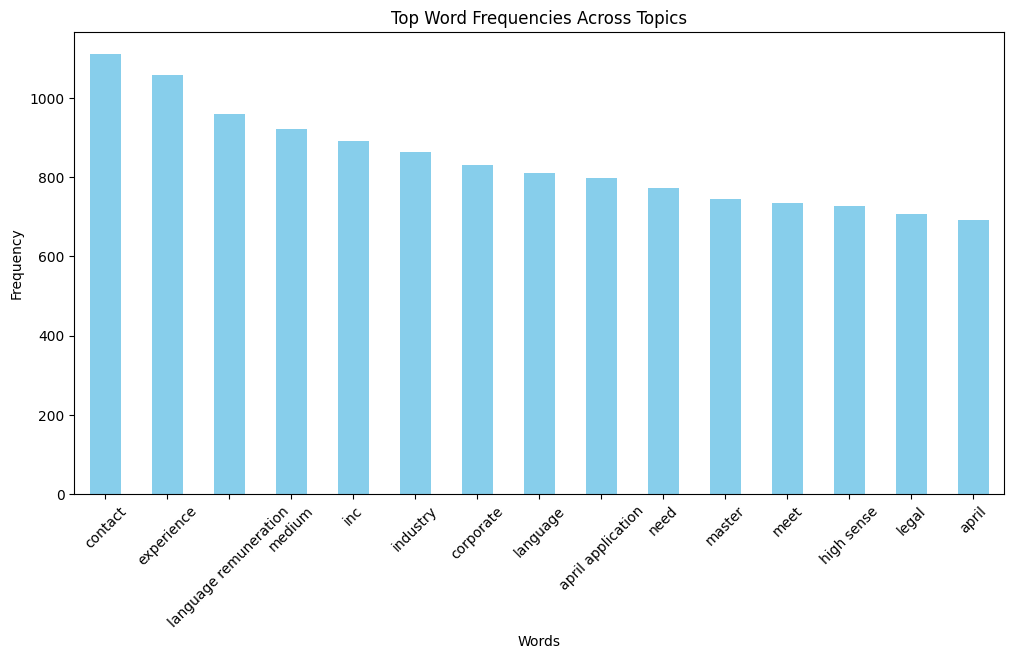

In [ ]:
# Counting word frequencies across topics
word_counts = pd.Series(np.array(lda.components_).flatten())
word_counts.index = np.repeat(words, lda.components_.shape[0])

# Plotting the most frequent words
top_words = word_counts.groupby(word_counts.index).sum().nlargest(n_top_words)
top_words.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Top Word Frequencies Across Topics')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.show()

# IT Job Classification

In [ ]:
jobs.shape

(18865, 26)

In [ ]:
jobs_processed.shape

(18865, 2)

In [ ]:
jobs_with_labels = pd.concat([jobs_processed, jobs['IT']], axis=1)

In [ ]:
jobs_with_labels

,Jobpost,Title,IT
0,ameria investment consult company job title ch...,chief financial officer,False
1,international research exchange board irex tit...,fulltime community connection intern pay inter...,False
2,caucasus environmental ngo network cenn job ti...,country coordinator,False
3,manoff group job title bcc specialist position...,bcc specialist,False
4,yerevan brandy company job title software deve...,software developer,True
...,...,...,...
18996,technolinguistic ngo title senior creative ux ...,senior creative ux ui designer,False
18997,cocacola hellenic bottle company armenia cjsc ...,category development manager,False
18998,cocacola hellenic bottle company armenia cjsc ...,operational marketing manager,False
18999,san lazzaro llc title head online sale departm...,head online sale department,False


In [ ]:
# Convert boolean values in the 'IT' column to binary integers (0 for False, 1 for True) and store the result in the 'IT' column
jobs_with_labels['IT'] = jobs_with_labels['IT'].apply(lambda x: 0 if x is False else 1)

In [ ]:
jobs_with_labels.head(5)

,Jobpost,Title,IT
0,ameria investment consult company job title ch...,chief financial officer,0
1,international research exchange board irex tit...,fulltime community connection intern pay inter...,0
2,caucasus environmental ngo network cenn job ti...,country coordinator,0
3,manoff group job title bcc specialist position...,bcc specialist,0
4,yerevan brandy company job title software deve...,software developer,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Assume 'jobpost' is the column with text data, and 'label' is the target variable
X_train, X_test, y_train, y_test = train_test_split(jobs_with_labels['Jobpost'], jobs_with_labels['IT'], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.fillna("")
X_test = X_test.fillna("")

In [ ]:
#Tokenization
# Vectorize the job posts with TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 0.05, max_df=0.95, stop_words='english', max_features=100)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_tfidf

<15092x100 sparse matrix of type '<class 'numpy.float64'>'
	with 668360 stored elements in Compressed Sparse Row format>

In [ ]:
from joblib import dump
# Save the fitted TfidfVectorizer
dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

In [ ]:
# Now resample the training set to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [ ]:
from collections import Counter
print('Original class distribution:', Counter(y_train))
print('Resampled class distribution:', Counter(y_train_resampled))

Original class distribution: Counter({0: 12071, 1: 3021})
Resampled class distribution: Counter({0: 12071, 1: 12071})


In [ ]:
print(X_train_resampled.shape)
print(X_test_tfidf.shape)
print(y_train_resampled.shape)
print(y_test.shape)

(24142, 100)
(3773, 100)
(24142,)
(3773,)


## Random Forest Model

In [ ]:
from joblib import load

# Load the model from the file
rf_model = load("random_forest_model.joblib")
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Fit the model
rf_model = RandomForestClassifier(max_features=25, n_estimators=180)
rf_model.fit(X_train_resampled, y_train_resampled)

In [ ]:
rf_train_predict = pd.DataFrame({'actual' : y_train_resampled,
                                 'predicted' : rf_model.predict(X_train_resampled)})
rf_train_predict.head(10)

,actual,predicted
0,0,0
1,1,1
2,0,0
3,0,0
4,1,1
5,1,1
6,0,0
7,0,0
8,0,0
9,0,0


In [ ]:
rf_test_predict = pd.DataFrame({'actual' : y_test,
                                 'predicted' : rf_model.predict(X_test_tfidf)})
rf_test_predict.head(10)

,actual,predicted
17721,1,1
17617,1,1
8660,0,0
13374,0,0
8743,0,0
4708,1,1
14950,0,0
16561,0,0
10202,0,0
14589,0,0


### Random Forest Model Evaluation

In [ ]:
# Check accuracy score on train and test
from sklearn import metrics

print('Accuracy Score for train dataset : ' , metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted))
print('Accuracy Score for test dataset : ' , metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted))

Accuracy Score for train dataset :  0.9814431281583962
Accuracy Score for test dataset :  0.9623641664457991


In [ ]:
# Check roc_auc score on train and test

print('ROC-AUC Score for train dataset : ' , metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted))
print('ROC-AUC Score for validation dataset : ' , metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted))

ROC-AUC Score for train dataset :  0.9814431281583962
ROC-AUC Score for validation dataset :  0.929042395330291


In [ ]:
# Calculate accuracy scores
train_accuracy = metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted)
test_accuracy = metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted)

# Calculate ROC-AUC scores
train_roc_auc = metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted)
test_roc_auc = metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted)

# Data for plotting
labels = ['Accuracy', 'ROC-AUC']
train_scores = [train_accuracy, train_roc_auc]
test_scores = [test_accuracy, test_roc_auc]
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

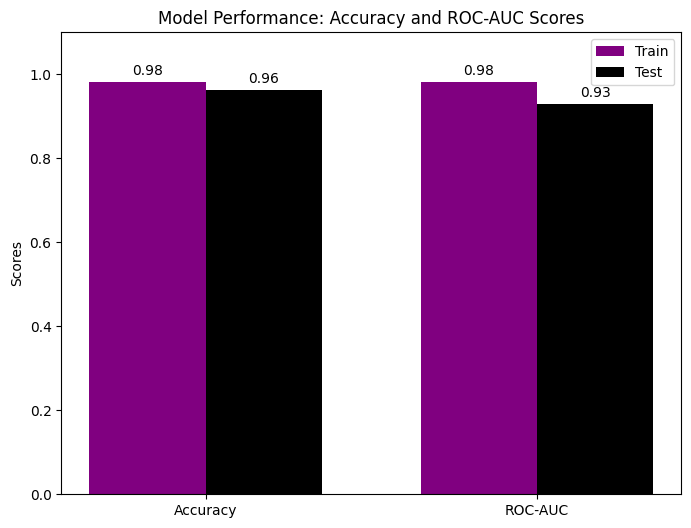

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train', color='purple')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test', color='black')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance: Accuracy and ROC-AUC Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add a label on top of each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to attach labels
add_labels(rects1)
add_labels(rects2)

# Adjusting the plot to make it more readable
plt.ylim(0, 1.1)  # Extend y-axis to make room for labels

plt.show()

<Axes: >

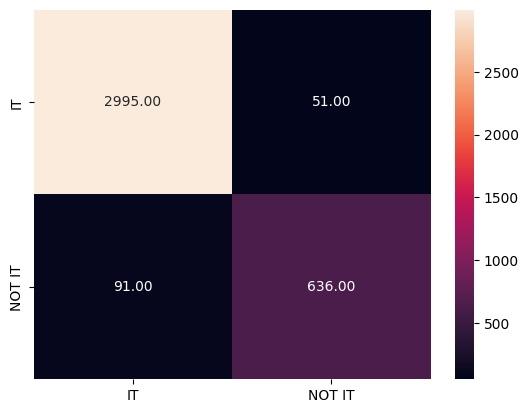

In [ ]:
# Create confusion matrix for Test aet
import seaborn as sns
conn_cm_test = metrics.confusion_matrix(rf_test_predict.actual, rf_test_predict.predicted)
sns.heatmap(conn_cm_test, fmt= '.2f', annot=True,  xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT'])

In [ ]:
#Create classification report
print(metrics.classification_report(rf_test_predict.actual, rf_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3046
           1       0.93      0.87      0.90       727

    accuracy                           0.96      3773
   macro avg       0.95      0.93      0.94      3773
weighted avg       0.96      0.96      0.96      3773



In [ ]:
# Get the feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get feature importances
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Convert to a DataFrame
feature_rank = pd.DataFrame(columns=['Rank', 'Feature', 'Importance'])

for f in range(X_train_resampled.shape[1]):  # Assuming X_train_resampled is the output from SMOTE
    feature_rank.loc[f] = [f + 1,
                           feature_names[indices[f]],
                           importances[indices[f]]]

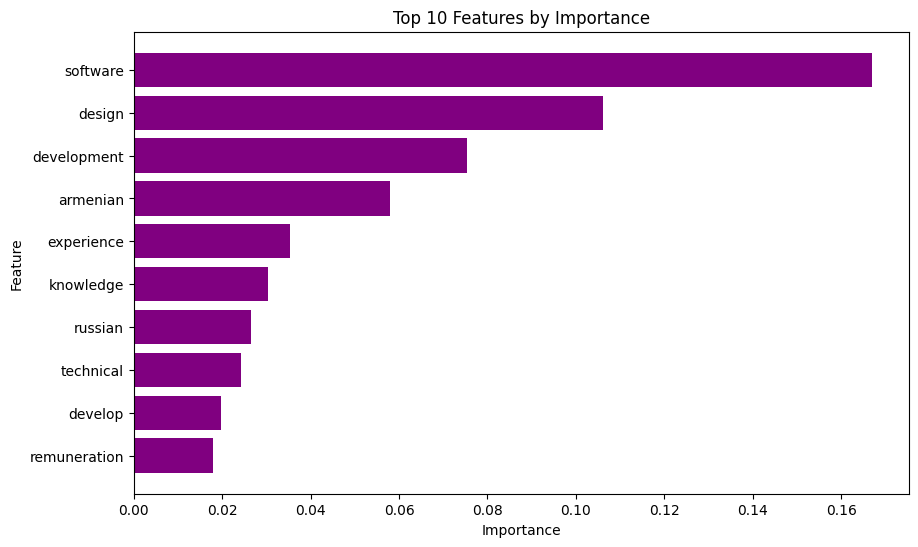

In [ ]:
top_features = feature_rank.head(10)

# Creating the plot
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.barh(top_features['Feature'], top_features['Importance'], color='purple')  # Create horizontal bar chart
plt.xlabel('Importance')  # Set the label for the x-axis
plt.ylabel('Feature')  # Set the label for the y-axis
plt.title('Top 10 Features by Importance')  # Set the title of the plot
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [ ]:
# Now 'feature_rank' DataFrame contains the ranks, feature names, and their importance scores
print(feature_rank.head(10))

   Rank       Feature  Importance
0     1      software    0.166944
1     2        design    0.106153
2     3   development    0.075479
3     4      armenian    0.058059
4     5    experience    0.035415
5     6     knowledge    0.030472
6     7       russian    0.026450
7     8     technical    0.024225
8     9       develop    0.019734
9    10  remuneration    0.017972


In [ ]:
feature_rank[10:]

,Rank,Feature,Importance
10,11,location yerevan,0.014736
11,12,remuneration salary,0.014610
12,13,prepare,0.014329
13,14,team,0.012856
14,15,salary,0.011613
...,...,...,...
95,96,interview,0.002671
96,97,university,0.002638
97,98,implementation,0.002551
98,99,implement,0.002483


In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Create a pipeline that first vectorizes the text and then applies the classifier
pipeline = make_pipeline(tfidf_vectorizer, rf_model)

# Instantiate the explainer
explainer = LimeTextExplainer(class_names=['Non-IT', 'IT'])

# Choose an instance to explain
idx = 40  # Index of the instance in the test set
text_instance = X_test.iloc[idx]

In [ ]:
# Correctly using the pipeline with raw text input
print('Document id: %d' % idx)
print('Predicted class =', rf_model.classes_[pipeline.predict([X_test.iloc[idx]]).astype(int)][0])
print('True class: %s' % y_test.iloc[idx])

Document id: 40
Predicted class = 1
True class: 1


In [ ]:
# Generate the explanation for the prediction with the correct input
exp = explainer.explain_instance(X_test.iloc[idx], pipeline.predict_proba, num_features=10)
exp.show_in_notebook(text=True)

In [ ]:
# Saving results for github
exp.save_to_file('lime_explanation_3.html')

In [ ]:
from joblib import dump
dump(rf_model, "random_forest_model.joblib")
print("Model saved successfully.")

##RNN Model

In [ ]:
from tensorflow.keras.models import load_model

rnn_model = load_model("rnn_model.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical

In [ ]:
# Convert the 'Jobpost' column to string, replacing NaN values with a placeholder
jobs_with_labels['Jobpost'] = jobs_with_labels['Jobpost'].fillna('missing').astype(str)

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(jobs_with_labels['Jobpost'])
X = tokenizer.texts_to_sequences(jobs_with_labels['Jobpost'])
X = pad_sequences(X, maxlen=100)  # Pad the sequences to a maximum length

In [ ]:
# Convert labels to categorical (one-hot encoding)
y = to_categorical(jobs_with_labels['IT'])

In [ ]:
# Split the data (after padding and tokenization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(2, activation='softmax'))  # Assuming binary classification ('0' or '1')

In [ ]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

Epoch 1/20
213/213 [==============================] - 43s 203ms/step - loss: 0.2381 - accuracy: 0.9155 - val_loss: 0.2311 - val_accuracy: 0.9205
Epoch 2/20
213/213 [==============================] - 40s 187ms/step - loss: 0.1892 - accuracy: 0.9350 - val_loss: 0.2353 - val_accuracy: 0.9179
Epoch 3/20
213/213 [==============================] - 40s 190ms/step - loss: 0.1630 - accuracy: 0.9436 - val_loss: 0.2372 - val_accuracy: 0.9152
Epoch 4/20
213/213 [==============================] - 41s 191ms/step - loss: 0.1394 - accuracy: 0.9554 - val_loss: 0.2594 - val_accuracy: 0.9119
Epoch 5/20
213/213 [==============================] - 44s 208ms/step - loss: 0.1229 - accuracy: 0.9591 - val_loss: 0.2719 - val_accuracy: 0.9179
Epoch 6/20
213/213 [==============================] - 40s 187ms/step - loss: 0.1064 - accuracy: 0.9661 - val_loss: 0.3059 - val_accuracy: 0.9053
Epoch 7/20
213/213 [==============================] - 39s 182ms/step - loss: 0.0952 - accuracy: 0.9692 - val_loss: 0.3381 - val_ac

###RNN Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on test data
rnn_predictions = rnn_model.predict(X_test)
rnn_predicted_classes = (rnn_predictions > 0.5).astype(int)

# Calculate metrics for the test set
rnn_accuracy_test = accuracy_score(y_test, rnn_predicted_classes)
rnn_precision_test = precision_score(y_test, rnn_predicted_classes, average='macro')
rnn_recall_test = recall_score(y_test, rnn_predicted_classes, average='macro')
rnn_f1_test = f1_score(y_test, rnn_predicted_classes, average='macro')


print("Test Set Performance:")
print(f"Accuracy: {rnn_accuracy_test}")
print(f"Precision: {rnn_precision_test}")
print(f"Recall: {rnn_recall_test}")
print(f"F1 Score: {rnn_f1_test}")
print("\n")

# Evaluate the model on train data
rnn_predictions = rnn_model.predict(X_train)
rnn_predicted_classes = (rnn_predictions > 0.5).astype(int)

# Calculate metrics for the train set
rnn_accuracy_train = accuracy_score(y_train, rnn_predicted_classes)
rnn_precision_train = precision_score(y_train, rnn_predicted_classes, average='macro')
rnn_recall_train = recall_score(y_train, rnn_predicted_classes, average='macro')
rnn_f1_train = f1_score(y_train, rnn_predicted_classes, average='macro')

print("Train Set Performance:")
print(f"Accuracy: {rnn_accuracy_train}")
print(f"Precision: {rnn_precision_train}")
print(f"Recall: {rnn_recall_train}")
print(f"F1 Score: {rnn_f1_train}")
print("\n")

118/118 [==============================] - 3s 24ms/step
Test Set Performance:
Accuracy: 0.9244632918102306
Precision: 0.8776755942053934
Recall: 0.8804357937575245
F1 Score: 0.8790458241307689


472/472 [==============================] - 10s 21ms/step
Train Set Performance:
Accuracy: 0.9796580970050358
Precision: 0.9709542084760292
Recall: 0.965196171466018
F1 Score: 0.9680414495400547




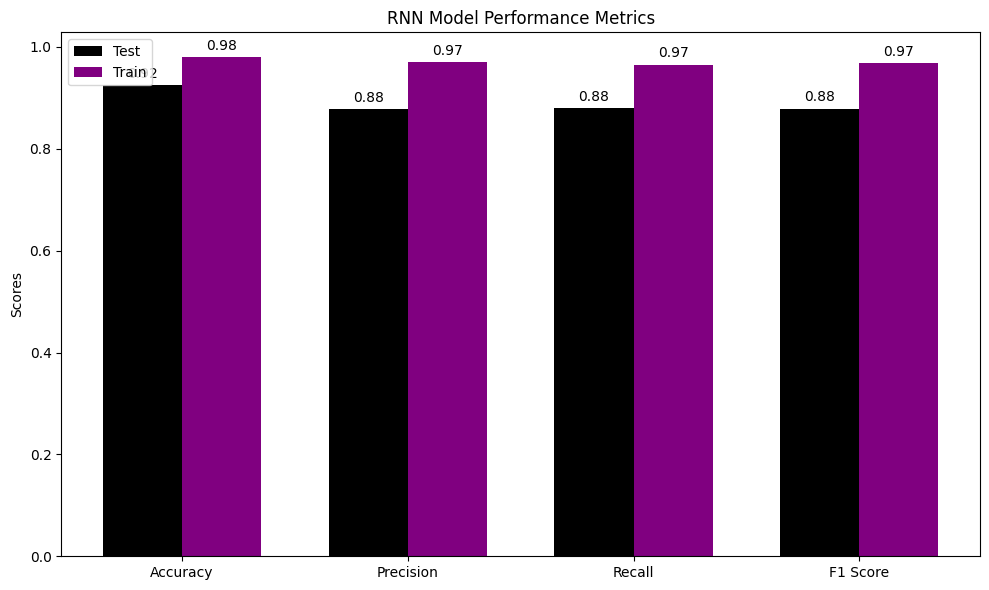

In [ ]:
rnn_test_performance = {
    "Accuracy": rnn_accuracy_test,
    "Precision": rnn_precision_test,
    "Recall": rnn_recall_test,
    "F1 Score": rnn_f1_test
}

rnn_train_performance = {
    "Accuracy": rnn_accuracy_train,
    "Precision": rnn_precision_train,
    "Recall": rnn_recall_train,
    "F1 Score": rnn_f1_train
}

labels = list(rnn_test_performance.keys())
test_scores = list(rnn_test_performance.values())
train_scores = list(rnn_train_performance.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, test_scores, width, label='Test', color='black')
rects2 = ax.bar(x + width/2, train_scores, width, label='Train', color='purple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('RNN Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to label the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

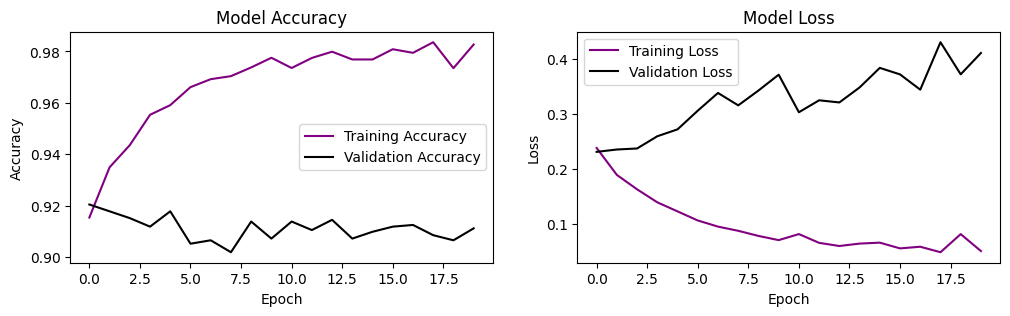

In [ ]:
# Plot training and validation accuracy per epoch with specified colors
plt.figure(figsize=(12, 3))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='purple')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.plot(history.history['val_loss'], label='Validation Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [ ]:
# Function to predict probabilities for text instances
def predict_proba(texts):
    # Convert texts to sequences and pad them to the same length as used in training
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    # Use the RNN to predict the probabilities
    return rnn_model.predict(padded_sequences)

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Non-IT', 'IT'])

idx = 1  # Example index
text_instance = jobs_with_labels['Jobpost'].iloc[idx]  # Selecting the job post at the given index

# Generate an explanation with at most 10 features
exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

# Show the explanation
print(exp.as_list())
exp.as_pyplot_figure()
plt.show()

In [ ]:
rnn_model.save("rnn_model.h5")
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


# Similarity of Job Titles

In [ ]:
from gensim.models import Doc2Vec

# Load the Doc2Vec model
model_sim = Doc2Vec.load("similarity_model.model")
print("Model loaded successfully.")

In [ ]:
jobs_processed.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [ ]:
# Initialize an empty list to store TaggedDocument objects
docs = []

# Function to tag documents
def fn_tag_doc(jobpost, title):
    return TaggedDocument(words=jobpost.split(), tags=[title])

In [ ]:
docs[0]

TaggedDocument(words=['ameria', 'investment', 'consult', 'company', 'job', 'title', 'chief', 'financial', 'officer', 'position', 'location', 'yerevan', 'armenia', 'job', 'description', 'ameria', 'investment', 'consult', 'company', 'seek', 'chief', 'financial', 'officer', 'position', 'manage', 'company', 'fiscal', 'administrative', 'function', 'provide', 'highly', 'responsible', 'technically', 'complex', 'staff', 'assistance', 'executive', 'director', 'work', 'perform', 'require', 'high', 'level', 'technical', 'proficiency', 'financial', 'management', 'investment', 'management', 'management', 'supervisory', 'administrative', 'skill', 'job', 'responsibility', 'supervise', 'financial', 'management', 'administrative', 'staff', 'include', 'assign', 'responsibility', 'review', 'employee', 'work', 'process', 'product', 'counsel', 'employee', 'give', 'performance', 'evaluation', 'recommend', 'disciplinary', 'action', 'serve', 'member', 'management', 'team', 'participate', 'strategic', 'operati

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# Apply the fn_tag_doc function to each row of the DataFrame jobs_processed and store the results in 'docs'
docs = [fn_tag_doc(x['Jobpost'], x['Title']) for _, x in jobs_processed.iterrows()]

In [ ]:
# Initialize and train the Doc2Vec model
model_sim = Doc2Vec(vector_size=100, dm=0, alpha=0.025, min_alpha=0.025, min_count=2, epochs=10)
model_sim.build_vocab(docs)
model_sim.train(docs, total_examples=model_sim.corpus_count, epochs=model_sim.epochs)

In [ ]:
# Save the trained model
model_sim.save("similarity_model.model")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
inferred_vector = model_sim.infer_vector('chef'.split())
similar_docs = model_sim.dv.most_similar([inferred_vector], topn=10)

In [ ]:
import pandas as pd

# Create a DataFrame named 'similarity' containing the similarity scores and corresponding job titles
similarity = pd.DataFrame(similar_docs, columns=['Job Title', 'Similarity Score'])

In [ ]:
similarity.head(10)

,Job Title,Similarity Score
0,pastry chef baker,0.760629
1,restaurant waiter waitress,0.700454
2,pastry chef,0.696074
3,chiefcook,0.695121
4,doorman,0.694105
5,chef cook,0.687694
6,executive chef,0.684305
7,chief cook,0.664097
8,fb manager,0.661400
9,cook,0.660793


In [ ]:
model_sim.save("similarity_model.model")
print("Model saved successfully.")


In the provided code above, a machine learning algorithm designed for natural language processing tasks. The model's primary function is to convert textual documents into numerical representations, facilitating the measurement of semantic similarity between documents. The process commences with the initialization of an empty list intended to hold TaggedDocument objects. These objects are a crucial component of the Doc2Vec model, as they pair each document in the dataset (a job posting in this context) with a unique tag (the job title), effectively preserving the document's identity in a format the model can process.

A custom function, fn_tag_doc, is defined to automate the creation of these TaggedDocument objects by splitting each job posting into a list of words (its 'words') and associating it with its job title (its 'tags'). This function is applied to each row of a pre-processed DataFrame named jobs_processed, transforming the job postings and titles into the format required for model training.

Following the preparation of the data, the Doc2Vec model is initialized with specific parameters, including the size of the vector representations and training details. The model then undergoes vocabulary building with the prepared documents and training over a defined number of epochs. Post-training, the model can infer a vector for any given document (in this case, the word 'Data analyst') and find the most similar documents within the trained dataset, returning these as a ranked list based on similarity scores. The final output is a DataFrame showcasing the top ten job titles most semantically similar to the query 'Data analyst', alongside their corresponding similarity scores, thus demonstrating the model's capability to understand and quantify semantic similarities within textual data.



